In [21]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

floor_price_round = 0.5 # TODO: levels per $ (2 / 2^2)
filename = 'AAPL_20180102.csv'

raw_columns = ['Date', 'Timestamp', 'OrderNumber', 'EventType', 'Price', 'Quantity', 'Exchange']
records = pd.read_csv(filename, usecols=raw_columns)

records['OrderNumber'] = records['Exchange'] + records['OrderNumber'].astype(str)

records['DateTime'] = records['Date'].apply(str) + ' ' + records['Timestamp']
records['DateTime'] = pd.to_datetime(records['DateTime'], format='%Y%m%d %H:%M:%S.%f')
records['Timestamp'] = records['DateTime'].values.astype(np.int64) // 10 ** 9

start_day_timestamp = int(records['DateTime'][0].timestamp())
records['time_index'] = np.int32((records['Timestamp'] - start_day_timestamp) / 60)  # index per minute

records['price_level'] = np.int32(records['Price'] * 2)  # index per minute

records = records.drop(['Date', 'DateTime', 'Timestamp', 'Exchange'], axis=1)

In [22]:
# full d configuration
num_layers = 5  # Price, Ordered volume, Filled volume, Canceled volume, Pending volume
num_price_levels = 500 * 2  # price level ($500), 50 cents per level (*2)
minutes_per_day = 16 * 60  # 960, 16 hours of data per day, from 4:00 to 20:00

full_d_asks = np.zeros((num_layers, num_price_levels, minutes_per_day), np.float32)
full_d_bids = np.zeros((num_layers, num_price_levels, minutes_per_day), np.float32)

incrementer = 0
for d_price_index in range(0, num_price_levels):
    for time_index in range(0, minutes_per_day):
        full_d_asks[0, d_price_index, time_index] = incrementer
    incrementer += floor_price_round

full_d_records = records\
    .loc[records['price_level'] < num_price_levels]\
    .loc[records['time_index'] < minutes_per_day]


def process_add_record(r, full_d):
    full_d[1, r.price_level, r.time_index] += r.Quantity

def process_trade_records(r, full_d):
    full_d[2, r.price_level, r.time_index] += r.Quantity

def process_execute_price_records(r, full_d):
    full_d[2, r.price_level, r.time_index] += r.Quantity


def process_execute_priceless_records(r, full_d):
    full_d[2, r.price_level_add, r.time_index_execute] += r.Quantity_execute

def process_fill_records(r, full_d):
    full_d[2, r.price_level_add, r.time_index_fill] += r.Quantity_add

def process_cancel_records(r, full_d):
    full_d[3, r.price_level_add, r.time_index_cancel] += r.Quantity_cancel

def process_delete_records(r, full_d):
    quantity = r.Quantity_delete if r.Quantity_delete != 0 else r.Quantity_add
    full_d[3, r.price_level_add, r.time_index_delete] += quantity


def process_side_records(side): # TODO:
    pass

full_d_price_records = full_d_records.loc[full_d_records['Price'] != 0]

full_d_price_records\
    .loc[full_d_price_records['EventType'] == 'ADD ASK']\
        .progress_apply(process_add_record, full_d=full_d_asks, axis=1)

full_d_asks[4] = full_d_asks[1]

full_d_price_records\
    .loc[full_d_price_records['EventType'] == 'TRADE ASK']\
        .progress_apply(process_trade_records, full_d=full_d_asks, axis=1)

full_d_price_records\
    .loc[full_d_price_records['EventType'] == 'EXECUTE ASK']\
        .progress_apply(process_execute_price_records, full_d=full_d_asks, axis=1)


full_d_priceless_records = full_d_records.loc[full_d_records['Price'] == 0]
add_asks = full_d_records.loc[full_d_records['EventType'] == 'ADD ASK'].set_index('OrderNumber')

fill_asks = full_d_priceless_records.loc[full_d_priceless_records['EventType'] == 'FILL ASK'].set_index('OrderNumber')
full_fill_asks = fill_asks.join(add_asks, on='OrderNumber', how='left', lsuffix='_fill', rsuffix='_add')
full_fill_asks\
    .loc[full_fill_asks['time_index_fill'] >= full_fill_asks['time_index_add']]\
        .progress_apply(process_fill_records, full_d=full_d_asks, axis=1)

execute_asks = full_d_priceless_records.loc[full_d_priceless_records['EventType'] == 'EXECUTE ASK'].set_index('OrderNumber')
full_execute_asks = execute_asks.join(add_asks, on='OrderNumber', how='left', lsuffix='_execute', rsuffix='_add')
full_execute_asks\
    .loc[full_execute_asks['time_index_execute'] >= full_execute_asks['time_index_add']]\
        .progress_apply(process_execute_priceless_records, full_d=full_d_asks, axis=1)

cancel_asks = full_d_priceless_records.loc[full_d_priceless_records['EventType'] == 'CANCEL ASK'].set_index('OrderNumber')
full_cancel_asks = cancel_asks.join(add_asks, on='OrderNumber', how='left', lsuffix='_cancel', rsuffix='_add')
full_cancel_asks\
    .loc[full_cancel_asks['time_index_cancel'] >= full_cancel_asks['time_index_add']]\
        .progress_apply(process_cancel_records, full_d=full_d_asks, axis=1)


delete_asks = full_d_priceless_records.loc[full_d_priceless_records['EventType'] == 'DELETE ASK'].set_index('OrderNumber')
full_delete_asks = delete_asks.join(add_asks, on='OrderNumber', how='left', lsuffix='_delete', rsuffix='_add')
full_delete_asks['price_level_add'] = np.int32(full_delete_asks['price_level_add']) # after join right table has wrong column types
full_delete_asks\
    .loc[full_delete_asks['time_index_delete'] >= full_delete_asks['time_index_add']]\
        .progress_apply(process_delete_records, full_d=full_d_asks, axis=1)


for p_index in range(0, num_price_levels):
    for t_index in range(0, minutes_per_day):
        full_d_asks[4, p_index, t_index] = \
            full_d_asks[4, p_index, t_index - 1 if t_index - 1 > 0 else 0] \
            + full_d_asks[1, p_index, t_index] \
            - full_d_asks[2, p_index, t_index] \
            - full_d_asks[3, p_index, t_index]


# TODO: BID
print()

100%|██████████| 288537/288537 [00:22<00:00, 12654.05it/s]


In [27]:
for p_index in range(0, num_price_levels):
    for t_index in range(0, minutes_per_day):
        full_d_asks[4, p_index, t_index] = \
            full_d_asks[4, p_index, t_index - 1 if t_index - 1 > 0 else 0] \
            + full_d_asks[1, p_index, t_index] \
            - full_d_asks[2, p_index, t_index] \
            - full_d_asks[3, p_index, t_index]

        if full_d_asks[4, p_index, t_index] < 0:
            full_d_asks[4, p_index, t_index]  = 0

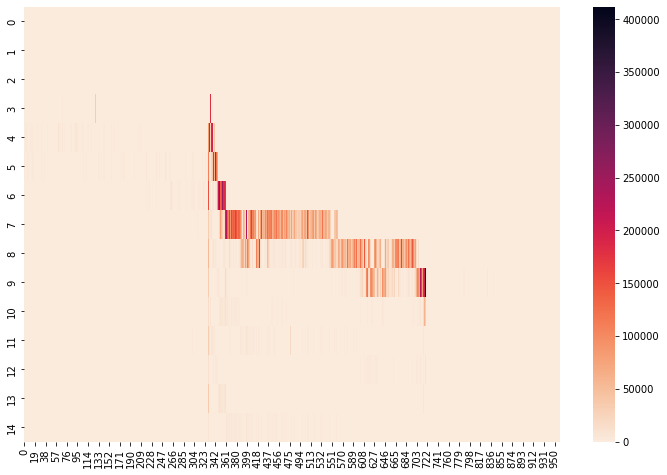

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(full_d_asks[1, 335:350], cmap='rocket_r')
plt.show()

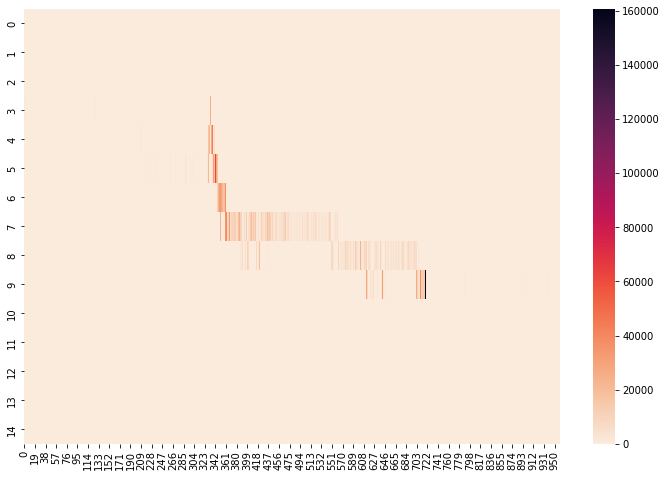

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(full_d_asks[2, 335:350], cmap='rocket_r')
plt.show()

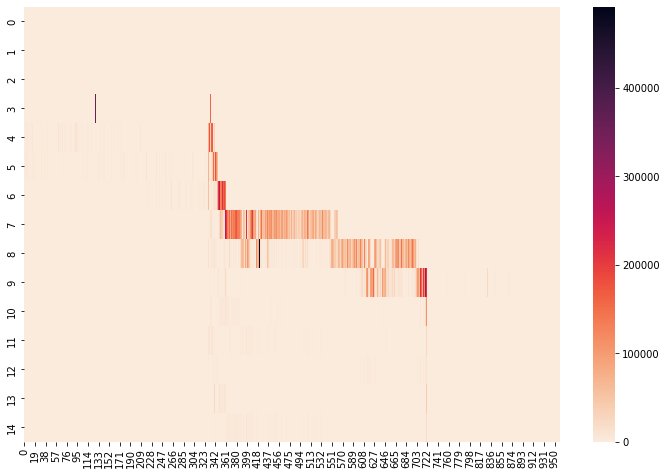

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(full_d_asks[3, 335:350], cmap='rocket_r')
plt.show()

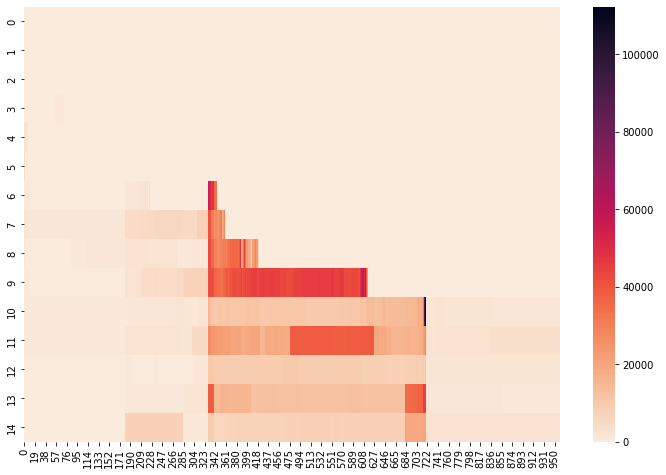

In [26]:
plt.figure(figsize=(12, 8))
full_d_asks[4, 335:350][full_d_asks[4, 335:350] < 0] = 0

sns.heatmap(full_d_asks[4, 335:350], cmap='rocket_r')
plt.show()

In [35]:
# working_hours = 330:720
full_d_asks[4, :, 330:720]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
num_layers = 5  # Price, Ordered volume, Filled volume, Canceled volume, Pending volume
num_price_levels = 10 * 2 * 2  # price level ($10) per 50 cents per level (*2) per side (*2)
minutes_per_day = 16 * 60 + 1  # 961, 16 hours of data per day, from 4:00 to 20:00

d = np.zeros((num_layers, num_price_levels, minutes_per_day), np.float32)

In [10]:
def process_records_time_groups(records_time_groups):
    # TODO: think of setting same middle price levels for asks and bids

    time_index = records_time_groups.iloc[0]['time_index']
    asks = records_time_groups.loc[records_time_groups['EventType'].str.contains('ASK')]
    bids = records_time_groups.loc[records_time_groups['EventType'].str.contains('BID')]

    non_zero_asks = asks.loc[asks['Price'] != 0].sort_values('Price', ascending=True)
    non_zero_bids = bids.loc[bids['Price'] != 0].sort_values('Price', ascending=False)

    if non_zero_asks.shape[0] != 0:
        lowest_ask = int(non_zero_asks.iloc[0]['Price'] * 2) / 2

        asks_incrementer = 0
        for d_price_index in range(int(num_price_levels / 2) - 1, 0 - 1, -1):
            d[0, d_price_index, time_index] = lowest_ask + asks_incrementer
            asks_incrementer += floor_price_round


        # if record.EventType == 'ADD ASK':
        #     return price, record.time_index

    if non_zero_bids.shape[0] != 0:
        highest_bid = int(non_zero_bids.iloc[0]['Price'] * 2) / 2

        bids_decrementer = 0
        for d_price_index in range(int(num_price_levels / 2), num_price_levels):
            d[0, d_price_index, time_index] = highest_bid - bids_decrementer
            bids_decrementer -= floor_price_round


records.groupby('time_index').progress_apply(process_records_time_groups)

  0%|          | 0/909 [00:00<?, ?it/s]

""


In [12]:
d[0]

array([[178.5, 179. , 179. , ..., 181.5, 181.5,   0. ],
       [178. , 178.5, 178.5, ..., 181. , 181. ,   0. ],
       [177.5, 178. , 178. , ..., 180.5, 180.5,   0. ],
       ...,
       [177.5, 177.5, 177. , ..., 180.5, 180.5,   0. ],
       [178. , 178. , 177.5, ..., 181. , 181. ,   0. ],
       [178.5, 178.5, 178. , ..., 181.5, 181.5,   0. ]], dtype=float32)

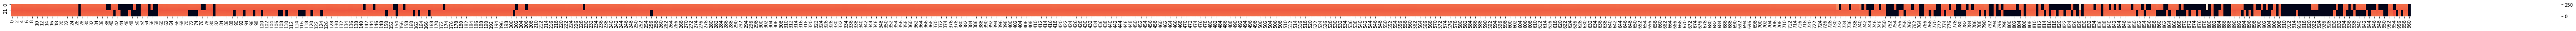

In [28]:
plt.figure(figsize=(120, 0.5))
sns.heatmap(d[0])
# plt.imshow(d[0], cmap='viridis')
plt.show()

In [5]:
records.sort_values('EventType').groupby('EventType').head(5)

,OrderNumber,EventType,Price,Quantity,time_index,index
928552,156893773,ADD ASK,171.96,400,628,928552
1010991,172444145,ADD ASK,171.92,900,670,1010991
1010990,172444141,ADD ASK,171.92,900,670,1010990
266062,5015388,ADD ASK,172.86,100,366,266062
633433,105671565,ADD ASK,171.45,100,487,633433
...,...,...,...,...,...,...
523797,0,TRADE BID,171.29,6,441,523797
273017,0,TRADE BID,171.24,1,368,273017
520790,0,TRADE BID,171.34,100,440,520790
294415,0,TRADE BID,171.20,20,373,294415


In [20]:
records.loc[records['EventType'] == 'DELETE ASK'].loc[records['Quantity'] == 0].sort_values('Quantity')

,OrderNumber,EventType,Price,Quantity,time_index,index
589,141137,DELETE ASK,0.0,0,0,589
811742,138935721,DELETE ASK,0.0,0,579,811742
811746,138954557,DELETE ASK,0.0,0,579,811746
811747,138965221,DELETE ASK,0.0,0,579,811747
811750,138954509,DELETE ASK,0.0,0,579,811750
...,...,...,...,...,...,...
436973,69609953,DELETE ASK,0.0,0,409,436973
436978,69622857,DELETE ASK,0.0,0,409,436978
436989,69622873,DELETE ASK,0.0,0,409,436989
436930,69603641,DELETE ASK,0.0,0,409,436930


In [24]:
records.loc[records['OrderNumber'] == 138776197]

,OrderNumber,EventType,Price,Quantity,time_index,index
809958,138776197,ADD ASK,171.65,100,578,809958
810443,138776197,DELETE ASK,0.00,0,579,810443


In [22]:
records.loc[records['time_index'] == 27]

,OrderNumber,EventType,Price,Quantity,time_index,index
2176,356617,CANCEL ASK,0.0,58,27,2176
2177,350985,CANCEL BID,0.0,29,27,2177
2178,357445,CANCEL BID,0.0,58,27,2178
2179,350985,CANCEL BID,0.0,116,27,2179


In [ ]:
normalized_file_columns = ['Timestamp', 'Asks', 'Bids']
index_col = normalized_file_columns[0]

normalized_df = pd.DataFrame(columns=normalized_file_columns).set_index(index_col)

In [162]:

updates['price'] = np.int64(updates['price'] / floor_price_round)
updates = updates.groupby(['timestamp', 'side', 'price']).sum().reset_index()

normalized_file_name = 'BTCUSDT_DEPTH_' + date + '.csv'
normalized_file_columns = ['unix', 'ascs', 'bids']
index_col = normalized_file_columns[0]
global normalized_df

normalized_df = pd.DataFrame(columns=normalized_file_columns).set_index(index_col)

updates.progress_apply(process_update, axis=1)

print('Saving csv.')
normalized_df.to_csv(normalized_file_name)

print('Moving result file to compressed/.')
os.rename(normalized_file_name, 'compressed/' + normalized_file_name)

print('Removing temp files.')
os.remove('BTCUSDT_T_DEPTH_' + date + '_depth_snap.csv')
os.remove('BTCUSDT_T_DEPTH_' + date + '_depth_update.csv')

with open('progress.txt', 'a') as file:
    date_datetime = datetime.datetime.strptime(date, "%Y-%m-%d")
    next_date = date_datetime + datetime.timedelta(days=1)
    next_date = str(next_date.date())
    file.write(next_date + "\n")

print('Done!')
print('Total processing time: ' + str(datetime.datetime.now() - startTime) + '\n')


def process_update(update):
    try:
        if update.side == 'a':
            normalized_df.loc[update.timestamp].ascs[update.price] = update.qty
        else:
            normalized_df.loc[update.timestamp].bids[update.price] = update.qty

    except:
        ascs = {}
        bids = {}

        if update.side == 'a':
            ascs[update.price] = update.qty
        else:
            bids[update.price] = update.qty

        normalized_df.loc[update.timestamp] = [ascs, bids]

In [124]:
records.sort_values('EventType').groupby('MPID').head(1)

,Date,Timestamp,OrderNumber,EventType,Ticker,Price,Quantity,MPID,Exchange,DateTime,index
928552,20180102,1514903297,156893773,ADD ASK,AAPL,171.96,400,NaN,NASDAQ,2018-01-02 14:28:17.837,37697
633433,20180102,1514894838,105671565,ADD ASK,AAPL,171.45,100,SBSH,NASDAQ,2018-01-02 12:07:18.226,29238
1114320,20180102,1514908219,191080869,ADD ASK,AAPL,178.62,100,UBSS,NASDAQ,2018-01-02 15:50:19.080,42619
630362,20180102,1514894736,105008769,ADD ASK,AAPL,174.83,100,SUNT,NASDAQ,2018-01-02 12:05:36.175,29136
630366,20180102,1514894736,105008777,ADD ASK,AAPL,179.13,100,IMCC,NASDAQ,2018-01-02 12:05:36.175,29136
630396,20180102,1514894736,105008821,ADD ASK,AAPL,178.25,600,GSCO,NASDAQ,2018-01-02 12:05:36.176,29136
630371,20180102,1514894736,105008793,ADD ASK,AAPL,179.98,100,CDRG,NASDAQ,2018-01-02 12:05:36.175,29136
1108368,20180102,1514908165,190025429,ADD ASK,AAPL,182.37,100,SGAS,NASDAQ,2018-01-02 15:49:25.296,42565
668429,20180102,1514895862,112287985,ADD ASK,AAPL,185.15,100,MSCO,NASDAQ,2018-01-02 12:24:22.850,30262
523744,20180102,1514892072,85262245,ADD ASK,AAPL,181.57,100,XGWD,NASDAQ,2018-01-02 11:21:12.421,26472


In [ ]:
r2 = records
.loc[records['EventType'] == 'DELETE ASK']
.loc[records['Quantity'] == 0]
.merge(right=records, on='OrderNumber')

In [ ]:
r2
.loc[r2['EventType_y'] == 'DELETE ASK']
# .loc[r2['Quantity_y'] == 0]
# .loc[r2['EventType_y'] != 'CANCEL ASK']\
# .sort_values('EventType_y').groupby('EventType_y').sum()